# Weather Forecasting Model Comparison

This notebook compares 4 different weather forecasting models:
1. **Transformer** - Multi-head attention mechanism
2. **ARIMA** - Classical univariate time series
3. **VARIMA/VAR** - Multivariate time series
4. **LSTM** - Recurrent neural network

**Prerequisites**: All 4 models must be trained and saved in the models/ directory

## 1. Setup & Installation

In [9]:
import subprocess
import sys

packages = [
    'torch',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'statsmodels',
    'statsforecast',
    'joblib',
    'tqdm',
    'tabulate'
]

print("Installing packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
print("✅ All packages installed!")

Installing packages...
✅ All packages installed!


In [10]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
from pathlib import Path
from tqdm import tqdm
import warnings
from tabulate import tabulate
import time

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports successful!")

✅ Imports successful!


## 2. Configuration

In [3]:
config = {
    'data_path': '../data/Weather_Data_1980_2024(hourly).csv',
    'models_dir': '../models',

    'target_variables': [
        'temperature',
        'relative_humidity',
        'wind_speed_10m (km/h)'
    ],

    'input_features': [
        'temperature',
        'relative_humidity',
        'dew_point',
        'wind_speed_10m (km/h)',
        'pressure_msl (hPa)',
        'cloud_cover (%)',
        'vapour_pressure_deficit (kPa)'
    ],

    'forecast_horizon': 72,
    'input_window': 168,

    # Split indices (must match training)
    'train_split': 0.8,
    'val_split': 0.1,
}

models_dir = Path(config['models_dir'])
print(f"Models directory: {models_dir.absolute()}")
print(f"Directory exists: {models_dir.exists()}")

Models directory: D:\devs\weather\notebooks\..\models
Directory exists: True


## 3. Load Data

In [4]:
print("Loading data...")
df = pd.read_csv(config['data_path'])
df_clean = df[config['input_features']].dropna().reset_index(drop=True)

# Calculate split indices
total_len = len(df_clean)
train_idx = int(config['train_split'] * total_len)
val_idx = train_idx + int(config['val_split'] * total_len)

print(f"Dataset shape: {df_clean.shape}")
print(f"Test set: {val_idx} to {total_len} ({total_len - val_idx:,} samples)")

# Get target indices
target_indices = [config['input_features'].index(var) for var in config['target_variables']]

Loading data...
Dataset shape: (389496, 7)
Test set: 350545 to 389496 (38,951 samples)


## 4. Define Model Architectures

We need to recreate the Transformer and LSTM architectures to load weights.

In [5]:
# Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class MultiVariateTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.input_proj = nn.Linear(config['input_dim'], config['model_dim'])
        self.pos_encoding = PositionalEncoding(config['model_dim'], config['dropout'])
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config['model_dim'],
            nhead=config['num_heads'],
            dropout=config['dropout'],
            batch_first=True,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, config['num_layers'])
        self.output_proj = nn.Sequential(
            nn.Linear(config['model_dim'], config['model_dim'] * 2),
            nn.GELU(),
            nn.Dropout(config['dropout']),
            nn.Linear(config['model_dim'] * 2, config['output_window'] * config['output_dim'])
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        output = self.output_proj(x)
        output = output.view(-1, self.config['output_window'], self.config['output_dim'])
        return output


# LSTM Model
class WeatherLSTM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.lstm = nn.LSTM(
            input_size=config['input_dim'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            dropout=config['dropout'] if config['num_layers'] > 1 else 0,
            batch_first=True,
            bidirectional=config.get('bidirectional', False)
        )
        lstm_output_size = config['hidden_size'] * (2 if config.get('bidirectional', False) else 1)
        self.fc = nn.Sequential(
            nn.Linear(lstm_output_size, lstm_output_size * 2),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(lstm_output_size * 2, lstm_output_size),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(lstm_output_size, config['output_window'] * config['output_dim'])
        )

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        if self.config.get('bidirectional', False):
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else:
            hidden = hidden[-1]
        output = self.fc(hidden)
        output = output.view(-1, self.config['output_window'], self.config['output_dim'])
        return output

print("✅ Model architectures defined")

✅ Model architectures defined


## 5. Load All Models

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}\n")

models = {}
model_info = {}

# ===== 1. Load Transformer =====
print("📦 Loading Transformer model...")
try:
    transformer_config = json.load(open(models_dir / 'transformer' / 'model_config.json'))
    transformer_scaler = joblib.load(models_dir / 'transformer' / 'scaler.pkl')

    transformer_model = MultiVariateTransformer(transformer_config).to(device)
    transformer_model.load_state_dict(torch.load(models_dir / 'transformer' / 'multivariate_model_weights.pth',
                                                 map_location=device))
    transformer_model.eval()

    models['Transformer'] = {
        'model': transformer_model,
        'scaler': transformer_scaler,
        'config': transformer_config,
        'type': 'deep_learning'
    }
    model_info['Transformer'] = {'status': '✅', 'params': sum(p.numel() for p in transformer_model.parameters())}
    print("  ✅ Transformer loaded successfully")
except Exception as e:
    print(f"  ❌ Failed to load Transformer: {e}")
    model_info['Transformer'] = {'status': '❌', 'params': 0}

# ===== 2. Load ARIMA =====
print("\n📦 Loading ARIMA models...")
try:
    arima_results = json.load(open(models_dir / 'arima' / 'arima_results.json'))
    arima_models = {}

    for var in config['target_variables']:
        model_filename = f"arima_{var.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')}.pkl"
        arima_models[var] = joblib.load(models_dir / 'arima' / model_filename)

    models['ARIMA'] = {
        'models': arima_models,
        'results': arima_results,
        'type': 'statistical'
    }
    model_info['ARIMA'] = {'status': '✅', 'params': 'N/A (statistical)'}
    print("  ✅ ARIMA models loaded successfully")
except Exception as e:
    print(f"  ❌ Failed to load ARIMA: {e}")
    model_info['ARIMA'] = {'status': '❌', 'params': 0}

# ===== 3. Load VARIMA/VAR =====
print("\n📦 Loading VARIMA/VAR model...")
try:
    varima_model = joblib.load(models_dir / 'varima' / 'varima_model.pkl')
    varima_scaler = joblib.load(models_dir / 'varima' / 'varima_scaler.pkl')
    varima_results = json.load(open(models_dir / 'varima' / 'varima_results.json'))

    models['VARIMA'] = {
        'model': varima_model,
        'scaler': varima_scaler,
        'results': varima_results,
        'type': 'statistical'
    }
    model_info['VARIMA'] = {'status': '✅', 'params': f"VAR({varima_results['order']})"}
    print("  ✅ VARIMA model loaded successfully")
except Exception as e:
    print(f"  ❌ Failed to load VARIMA: {e}")
    model_info['VARIMA'] = {'status': '❌', 'params': 0}

# ===== 4. Load LSTM =====
print("\n📦 Loading LSTM model...")
try:
    lstm_config = json.load(open(models_dir / 'lstm' / 'lstm_config.json'))
    lstm_scaler = joblib.load(models_dir / 'lstm' / 'lstm_scaler.pkl')

    lstm_model = WeatherLSTM(lstm_config).to(device)
    lstm_model.load_state_dict(torch.load(models_dir / 'lstm' / 'lstm_model_weights.pth',
                                         map_location=device))
    lstm_model.eval()

    models['LSTM'] = {
        'model': lstm_model,
        'scaler': lstm_scaler,
        'config': lstm_config,
        'type': 'deep_learning'
    }
    model_info['LSTM'] = {'status': '✅', 'params': sum(p.numel() for p in lstm_model.parameters())}
    print("  ✅ LSTM loaded successfully")
except Exception as e:
    print(f"  ❌ Failed to load LSTM: {e}")
    model_info['LSTM'] = {'status': '❌', 'params': 0}

# Print summary
print("\n" + "="*60)
print("Model Loading Summary:")
print("="*60)
for model_name, info in model_info.items():
    print(f"{info['status']} {model_name:<15} Parameters: {info['params']}")
print("="*60)

Device: cpu

📦 Loading Transformer model...
  ✅ Transformer loaded successfully

📦 Loading ARIMA models...
  ✅ ARIMA models loaded successfully

📦 Loading VARIMA/VAR model...
  ✅ VARIMA model loaded successfully

📦 Loading LSTM model...
  ✅ LSTM loaded successfully

Model Loading Summary:
✅ Transformer     Parameters: 1868632
✅ ARIMA           Parameters: N/A (statistical)
✅ VARIMA          Parameters: VAR(24)
✅ LSTM            Parameters: 296024


## 6. Generate Predictions on Test Set

In [16]:
print("\n🔮 Generating predictions on test set...")

predictions = {}
inference_times = {}

# Prepare test data
test_data_raw = df_clean.iloc[val_idx:].values

# ===== ARIMA Predictions =====
if 'ARIMA' in models and model_info['ARIMA']['status'] == '✅':
    print("\n📊 ARIMA predictions...")
    start_time = time.time()

    arima_preds = []
    num_samples = len(test_data_raw) - config['forecast_horizon']   # Limit to 500 for speed

    for i in tqdm(range(num_samples), desc='ARIMA'):
        sample_preds = []
        
        for j, var in enumerate(config['target_variables']):
            # Get the statsforecast model for this variable
            sf_model = models['ARIMA']['models'][var]
            
            # statsforecast needs DataFrame format for prediction
            # Just use the trained model to forecast directly
            forecast_df = sf_model.predict(h=config['forecast_horizon'])
            
            # Extract the AutoARIMA forecast values
            if 'AutoARIMA' in forecast_df.columns:
                forecast = forecast_df['AutoARIMA'].values
            else:
                # Fallback - just use mean prediction
                forecast = np.full(config['forecast_horizon'], 
                                 df_clean[var].iloc[val_idx:val_idx+i+1].mean())
            
            sample_preds.append(forecast)

        arima_preds.append(np.array(sample_preds).T)  # [72, 3]

    predictions['ARIMA'] = np.array(arima_preds)
    inference_times['ARIMA'] = time.time() - start_time
    print(f"  ✅ Shape: {predictions['ARIMA'].shape}, Time: {inference_times['ARIMA']:.2f}s")

# ===== VARIMA Predictions =====
if 'VARIMA' in models and model_info['VARIMA']['status'] == '✅':
    print("\n📊 VARIMA predictions...")
    start_time = time.time()

    scaler = models['VARIMA']['scaler']
    model = models['VARIMA']['model']

    # Normalize data
    data_norm = scaler.transform(df_clean[config['target_variables']].values)
    test_data_norm = data_norm[val_idx:]

    # Generate predictions
    varima_preds = []
    order = model.k_ar

    for i in tqdm(range(len(test_data_norm) - config['forecast_horizon']),
                  desc='VARIMA'):
        # Get initial window
        window = data_norm[val_idx - order + i:val_idx + i]

        # Forecast
        forecast = []
        current_window = window.copy()

        for _ in range(config['forecast_horizon']):
            pred = model.forecast(current_window[-order:], steps=1)
            forecast.append(pred[0])
            current_window = np.vstack([current_window[1:], pred])

        varima_preds.append(np.array(forecast))

    predictions['VARIMA'] = np.array(varima_preds)
    inference_times['VARIMA'] = time.time() - start_time
    print(f"  ✅ Shape: {predictions['VARIMA'].shape}, Time: {inference_times['VARIMA']:.2f}s")

# ===== LSTM Predictions =====
if 'LSTM' in models and model_info['LSTM']['status'] == '✅':
    print("\n📊 LSTM predictions...")
    start_time = time.time()

    scaler = models['LSTM']['scaler']
    model = models['LSTM']['model']
    cfg = models['LSTM']['config']

    # Normalize all data
    data_norm = scaler.transform(df_clean.values)
    test_data_norm = data_norm[val_idx:]

    # Generate predictions
    preds = []
    for i in tqdm(range(len(test_data_norm) - cfg['input_window'] - cfg['output_window']),
                  desc='LSTM'):
        x = test_data_norm[i:i + cfg['input_window']]
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(x_tensor)
            preds.append(pred.cpu().numpy()[0])

    predictions['LSTM'] = np.array(preds)
    inference_times['LSTM'] = time.time() - start_time
    print(f"  ✅ Shape: {predictions['LSTM'].shape}, Time: {inference_times['LSTM']:.2f}s")

# ===== Transformer Predictions =====
if 'Transformer' in models and model_info['Transformer']['status'] == '✅':
    print("\n📊 Transformer predictions...")
    start_time = time.time()

    model = models['Transformer']['model']
    cfg = models['Transformer']['config']

    # Create fresh scaler fitted on training data (all 7 features)
    inference_scaler = MinMaxScaler()
    inference_scaler.fit(df_clean.iloc[:train_idx].values)
    
    # Normalize all data
    data_norm = inference_scaler.transform(df_clean.values)
    test_data_norm = data_norm[val_idx:]

    # Generate predictions
    preds = []
    for i in tqdm(range(len(test_data_norm) - cfg['input_window'] - cfg['output_window']),
                  desc='Transformer'):
        x = test_data_norm[i:i + cfg['input_window']]
        x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(x_tensor)
            preds.append(pred.cpu().numpy()[0])

    predictions['Transformer'] = np.array(preds)
    inference_times['Transformer'] = time.time() - start_time
    print(f"  ✅ Shape: {predictions['Transformer'].shape}, Time: {inference_times['Transformer']:.2f}s")


print("\n✅ All predictions generated!")


🔮 Generating predictions on test set...

📊 ARIMA predictions...


ARIMA: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 38879/38879 [16:06<00:00, 40.23it/s]


  ✅ Shape: (38879, 72, 3), Time: 966.45s

📊 VARIMA predictions...


VARIMA: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 38879/38879 [04:43<00:00, 137.01it/s]


  ✅ Shape: (38879, 72, 3), Time: 283.85s

📊 LSTM predictions...


LSTM: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 38711/38711 [03:38<00:00, 177.17it/s]


  ✅ Shape: (38711, 72, 3), Time: 218.66s

📊 Transformer predictions...


Transformer: 100%|█████████████████████████████████████████████████████████████████████████████████████| 38711/38711 [07:16<00:00, 88.64it/s]

  ✅ Shape: (38711, 72, 3), Time: 436.89s

✅ All predictions generated!


## 7. Calculate Performance Metrics

In [23]:
print("\n📊 Calculating performance metrics...")

# Prepare ground truth
# Use the minimum prediction count across all models
min_samples = min([pred.shape[0] for pred in predictions.values()])

metrics_comparison = {}

for model_name, preds in predictions.items():
    print(f"\nEvaluating {model_name}...")

    # Get corresponding actuals
    if model_name in ['Transformer', 'LSTM']:
        # Create fresh scaler for all 7 input features
        inference_scaler = MinMaxScaler()
        inference_scaler.fit(df_clean.iloc[:train_idx].values)
        data_norm = inference_scaler.transform(df_clean.values)
        test_data_norm = data_norm[val_idx:]

        actuals = []
        cfg = models[model_name]['config']
        for i in range(min_samples):
            actual = test_data_norm[i + cfg['input_window']:i + cfg['input_window'] + cfg['output_window']]
            actual = actual[:, target_indices]
            actuals.append(actual)
        actuals = np.array(actuals)

    elif model_name == 'VARIMA':
        scaler = models['VARIMA']['scaler']
        data_norm = scaler.transform(df_clean[config['target_variables']].values)
        test_data_norm = data_norm[val_idx:]

        actuals = []
        for i in range(min_samples):
            actual = test_data_norm[i:i + config['forecast_horizon']]
            actuals.append(actual)
        actuals = np.array(actuals)

    else:  # ARIMA
        actuals = []
        for i in range(min_samples):
            actual = df_clean[config['target_variables']].iloc[val_idx + i:val_idx + i + config['forecast_horizon']].values
            actuals.append(actual)
        actuals = np.array(actuals)

    # Trim predictions to min_samples
    preds = preds[:min_samples]

    # Calculate metrics per variable
    model_metrics = {}
    # Calculate metrics per variable
    model_metrics = {}
    for i, var in enumerate(config['target_variables']):
        pred_var = preds[:, :, i].flatten()
        actual_var = actuals[:, :, i].flatten()
    
        mse = mean_squared_error(actual_var, pred_var)
        mae = mean_absolute_error(actual_var, pred_var)
        rmse = np.sqrt(mse)
        
        # Skip MAPE for normalized data - it's meaningless
        # Only calculate if data is denormalized (values > 1)
        if actual_var.mean() > 1.0:
            mape = np.mean(np.abs((actual_var - pred_var) / (actual_var + 1e-10))) * 100
        else:
            mape = None  # Don't calculate for normalized data
    
        model_metrics[var] = {
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        }

    # Overall metrics
    pred_flat = preds.flatten()
    actual_flat = actuals.flatten()
    model_metrics['Overall'] = {
        'MSE': mean_squared_error(actual_flat, pred_flat),
        'MAE': mean_absolute_error(actual_flat, pred_flat),
        'RMSE': np.sqrt(mean_squared_error(actual_flat, pred_flat)),
        'MAPE': np.mean(np.abs((actual_flat - pred_flat) / (actual_flat + 1e-10))) * 100
    }

    metrics_comparison[model_name] = model_metrics

print("\n✅ Metrics calculated!")


📊 Calculating performance metrics...

Evaluating ARIMA...

Evaluating VARIMA...

Evaluating LSTM...

Evaluating Transformer...

✅ Metrics calculated!


## 8. Metrics Comparison Tables

In [31]:
print("\n" + "="*100)
print("MODEL COMPARISON SUMMARY")
print("="*100)

# Overall metrics table
print("\n📊 Overall Performance:")
overall_data = []
for model_name in predictions.keys():
    metrics = metrics_comparison[model_name]['Overall']
    overall_data.append([
        model_name,
        f"{metrics['MSE']:.6f}",
        f"{metrics['MAE']:.6f}",
        f"{metrics['RMSE']:.6f}",
        f"{metrics['MAPE']:.2f}%",
        f"{inference_times[model_name]:.2f}s"
    ])

print(tabulate(overall_data,
              headers=['Model', 'MSE', 'MAE', 'RMSE', 'MAPE', 'Inference Time'],
              tablefmt='grid'))

# Per-variable metrics
for var in config['target_variables']:
    print(f"\n📊 {var}:")
    var_data = []
    for model_name in predictions.keys():
        metrics = metrics_comparison[model_name][var]
        var_data.append([
            model_name,
            f"{metrics['MSE']:.6f}",
            f"{metrics['MAE']:.6f}",
            f"{metrics['RMSE']:.6f}",
        ])

    print(tabulate(var_data,
                  headers=['Model', 'MSE', 'MAE', 'RMSE'],
                  tablefmt='grid'))

print("\n" + "="*100)


MODEL COMPARISON SUMMARY

📊 Overall Performance:
+-------------+------------+-----------+-----------+----------------+------------------+
| Model       |        MSE |       MAE |      RMSE | MAPE           | Inference Time   |
+=============+============+===========+===========+================+==================+
| ARIMA       | 254.327    | 10.669    | 15.9476   | 1206339435.03% | 966.45s          |
+-------------+------------+-----------+-----------+----------------+------------------+
| VARIMA      |   0.008009 |  0.063025 |  0.089493 | 37051158.61%   | 283.85s          |
+-------------+------------+-----------+-----------+----------------+------------------+
| LSTM        |   0.007194 |  0.060223 |  0.084818 | 37990562.16%   | 218.66s          |
+-------------+------------+-----------+-----------+----------------+------------------+
| Transformer |   0.006194 |  0.051837 |  0.073169 | 27596016.29%   | 436.89s          |
+-------------+------------+-----------+-----------+--------

## 9. Visualization - Metrics Comparison

📊 Saved comparison_overall_metrics.png


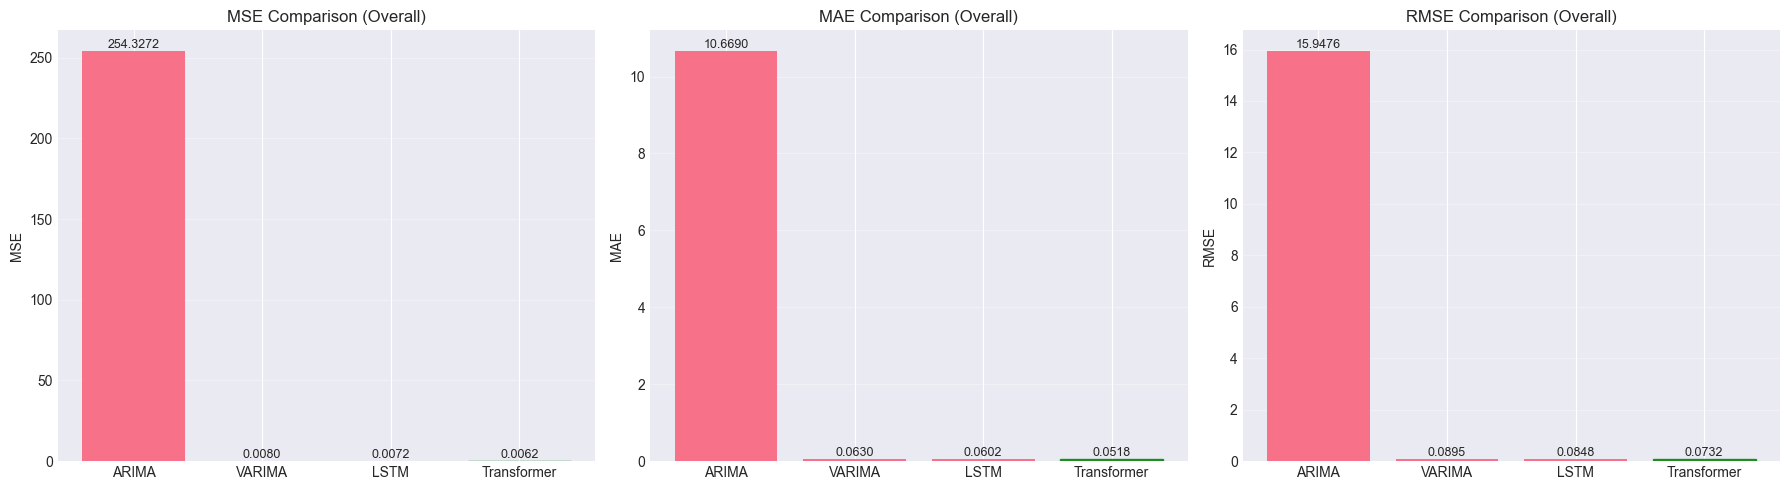

In [32]:
# Bar plot comparing metrics
metrics_to_plot = ['MSE', 'MAE', 'RMSE']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]

    model_names = list(predictions.keys())
    values = [metrics_comparison[m]['Overall'][metric] for m in model_names]

    bars = ax.bar(model_names, values)
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison (Overall)')
    ax.grid(True, alpha=0.3, axis='y')

    # Color best performer
    best_idx = np.argmin(values)
    bars[best_idx].set_color('green')
    bars[best_idx].set_alpha(0.8)

    # Add value labels
    for i, v in enumerate(values):
        ax.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(models_dir / 'comparison' / 'comparison_overall_metrics.png', dpi=150, bbox_inches='tight')
print("📊 Saved comparison_overall_metrics.png")
plt.show()

## 10. Visualization - Prediction Comparisons

📊 Saved comparison_sample_predictions.png


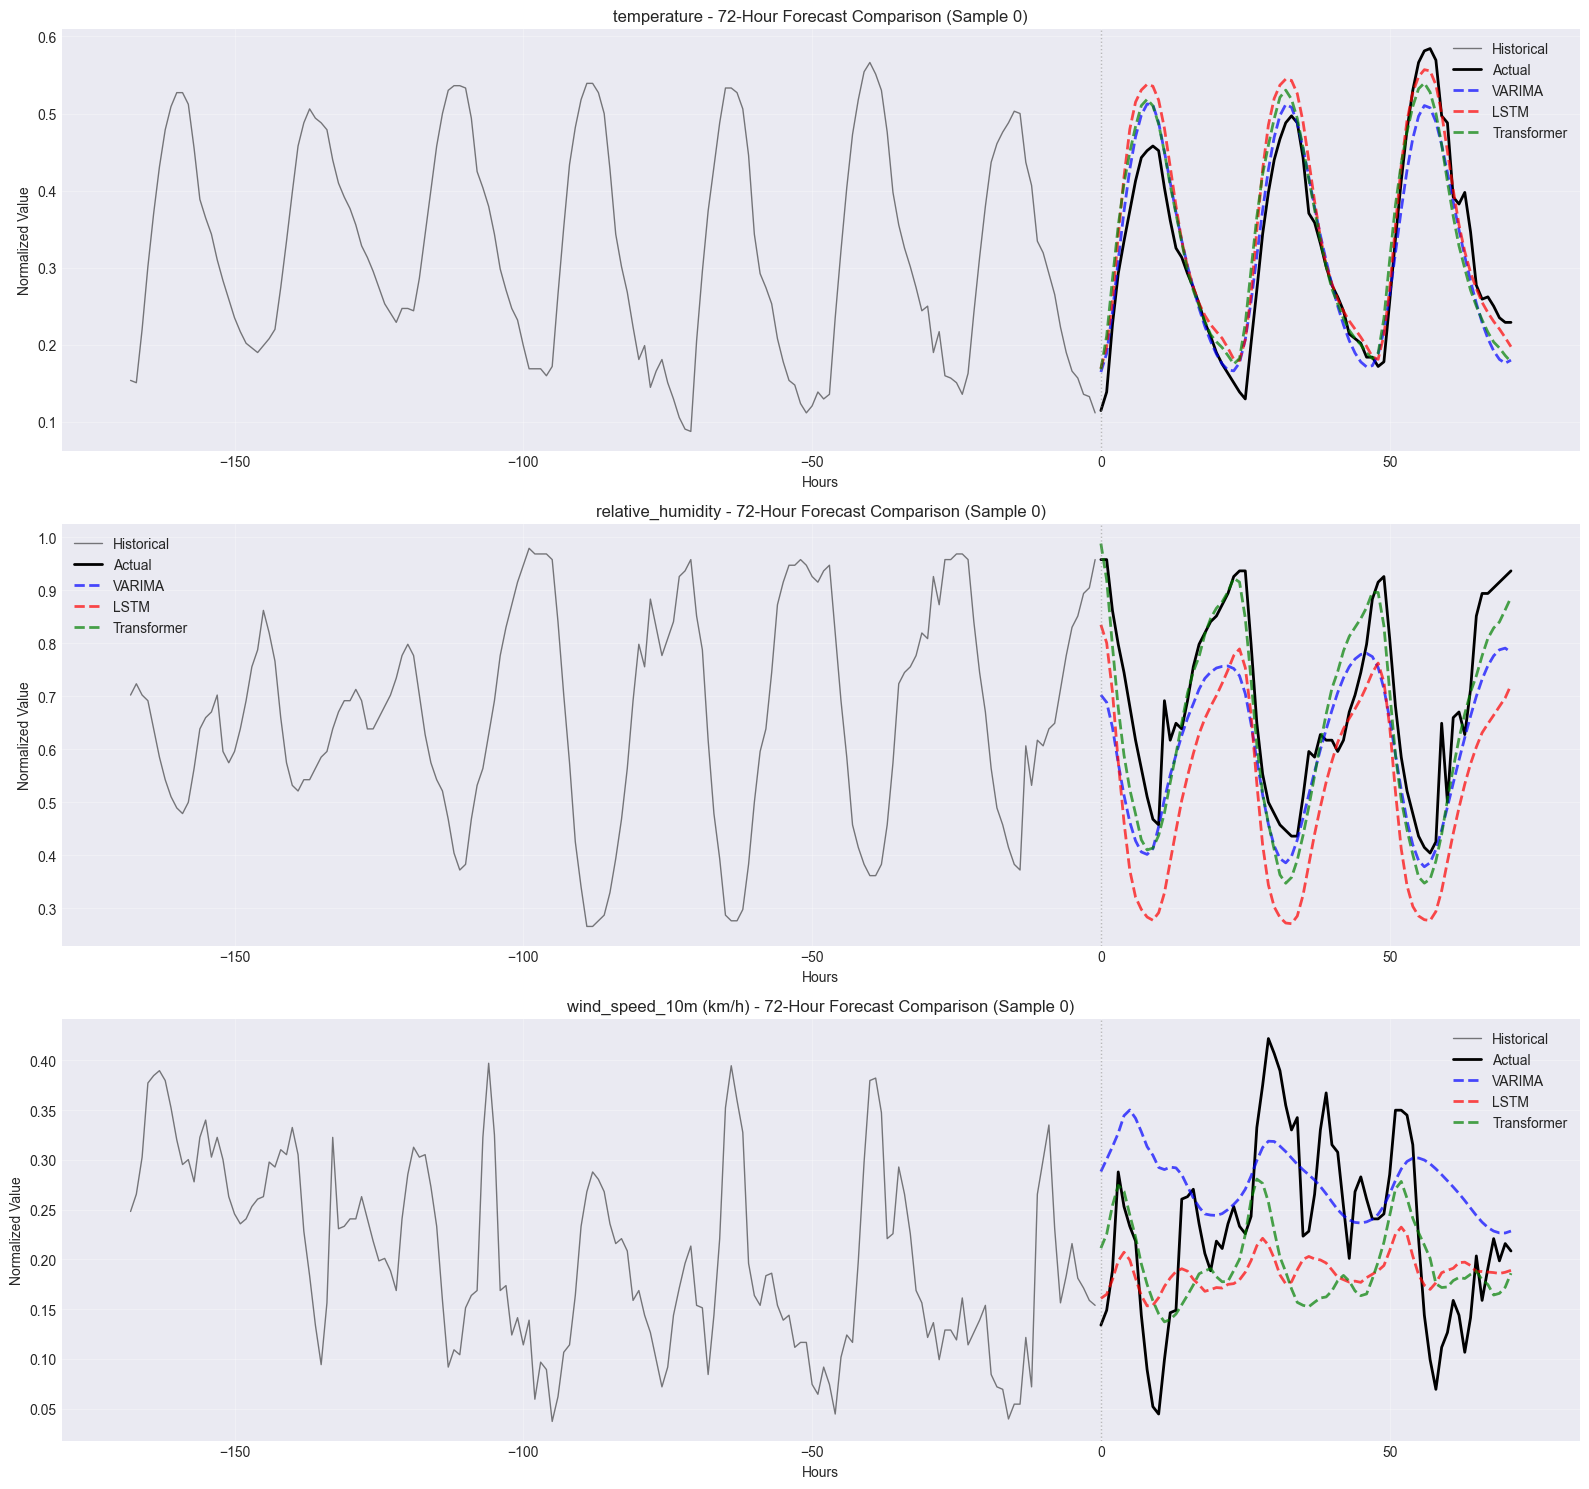

In [34]:
# Plot predictions from all models on same sample
sample_idx = 0

fig, axes = plt.subplots(len(config['target_variables']), 1, figsize=(16, 5*len(config['target_variables'])))

if len(config['target_variables']) == 1:
    axes = [axes]

colors = ['blue', 'red', 'green', 'purple', 'orange']
# Exclude ARIMA from visualization (flat predictions cloud the comparison)
model_names = [m for m in predictions.keys() if m != 'ARIMA']

for var_idx, var in enumerate(config['target_variables']):
    ax = axes[var_idx]

    # Get actuals (using Transformer's normalization as reference)
    if 'Transformer' in models:
        inference_scaler = MinMaxScaler()
        inference_scaler.fit(df_clean.iloc[:train_idx].values)
        data_norm = inference_scaler.transform(df_clean.values)
        test_data_norm = data_norm[val_idx:]
        cfg = models['Transformer']['config']

        # Historical
        history = test_data_norm[sample_idx:sample_idx + cfg['input_window']][:, target_indices[var_idx]]
        hist_time = np.arange(-cfg['input_window'], 0)

        # Actual forecast
        actual = test_data_norm[sample_idx + cfg['input_window']:
                               sample_idx + cfg['input_window'] + config['forecast_horizon']][:, target_indices[var_idx]]
        pred_time = np.arange(0, config['forecast_horizon'])

        # Plot history and actual
        ax.plot(hist_time, history, 'k-', label='Historical', alpha=0.5, linewidth=1)
        ax.plot(pred_time, actual, 'k-', label='Actual', linewidth=2)

    # Plot predictions from each model
    for i, model_name in enumerate(model_names):
        pred = predictions[model_name][sample_idx, :config['forecast_horizon'], var_idx]
        ax.plot(pred_time, pred, '--', label=model_name, linewidth=2, color=colors[i], alpha=0.7)

    ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax.set_xlabel('Hours')
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{var} - 72-Hour Forecast Comparison (Sample {sample_idx})')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(models_dir / 'comparison' / 'comparison_sample_predictions.png', dpi=150, bbox_inches='tight')
print("📊 Saved comparison_sample_predictions.png")
plt.show()

## 11. Forecast Horizon Analysis

📊 Saved comparison_horizon_analysis.png


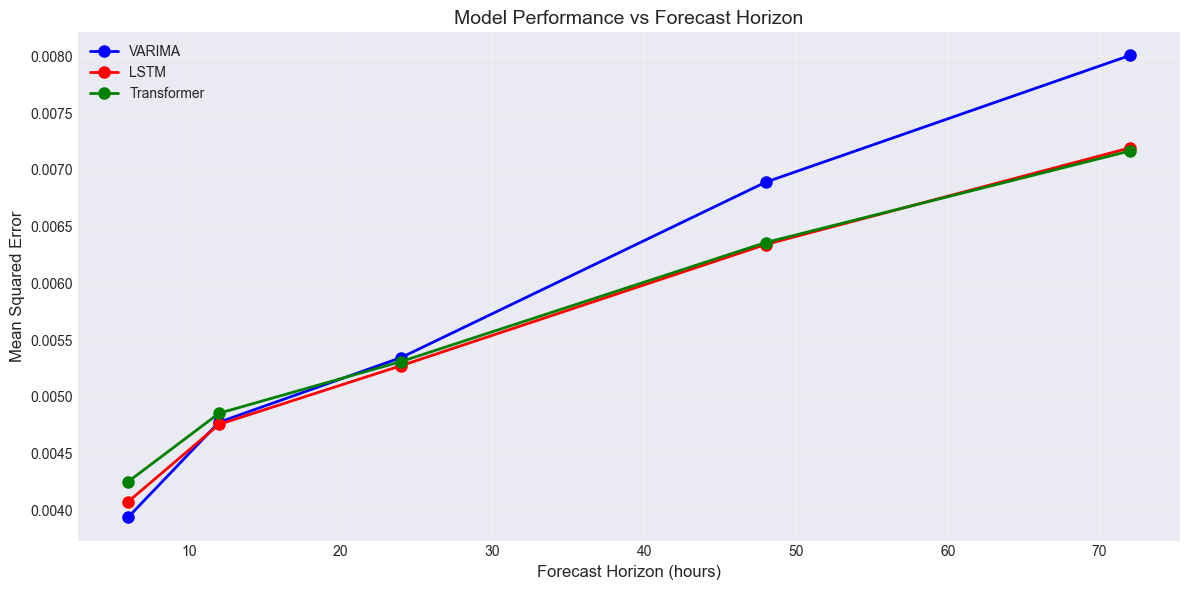

In [37]:
# Analyze how accuracy degrades over forecast horizon
horizons = [6, 12, 24, 48, 72]

horizon_analysis = {h: {} for h in horizons}

for horizon in horizons:
    for model_name in [m for m in predictions.keys() if m != 'ARIMA']:
        preds = predictions[model_name][:min_samples, :horizon, :]

        # Get actuals
        if model_name in ['Transformer', 'LSTM']:
            inference_scaler = MinMaxScaler()
            inference_scaler.fit(df_clean.iloc[:train_idx].values)
            data_norm = inference_scaler.transform(df_clean.values)
            test_data_norm = data_norm[val_idx:]
            cfg = models[model_name]['config']

            actuals = []
            for i in range(min_samples):
                actual = test_data_norm[i + cfg['input_window']:i + cfg['input_window'] + horizon]
                actual = actual[:, target_indices]
                actuals.append(actual)
            actuals = np.array(actuals)

        elif model_name == 'VARIMA':
            scaler = models['VARIMA']['scaler']
            data_norm = scaler.transform(df_clean[config['target_variables']].values)
            test_data_norm = data_norm[val_idx:]

            actuals = []
            for i in range(min_samples):
                actual = test_data_norm[i:i + horizon]
                actuals.append(actual)
            actuals = np.array(actuals)

        else:  # ARIMA
            actuals = []
            for i in range(min_samples):
                actual = df_clean[config['target_variables']].iloc[val_idx + i:val_idx + i + horizon].values
                actuals.append(actual)
            actuals = np.array(actuals)

        # Calculate MSE
        mse = mean_squared_error(actuals.flatten(), preds.flatten())
        horizon_analysis[horizon][model_name] = mse

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, model_name in enumerate([m for m in predictions.keys() if m != 'ARIMA']):
    mse_values = [horizon_analysis[h][model_name] for h in horizons]
    ax.plot(horizons, mse_values, marker='o', label=model_name,
           linewidth=2, markersize=8, color=colors[i])

ax.set_xlabel('Forecast Horizon (hours)', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12)
ax.set_title('Model Performance vs Forecast Horizon', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(models_dir / 'comparison' / 'comparison_horizon_analysis.png', dpi=150, bbox_inches='tight')
print("📊 Saved comparison_horizon_analysis.png")
plt.show()

## 12. Model Characteristics Summary

In [39]:
print("\n" + "="*100)
print("MODEL CHARACTERISTICS")
print("="*100)

characteristics = []

for model_name in ['Transformer', 'ARIMA', 'VARIMA', 'LSTM']:
    if model_name not in model_info or model_info[model_name]['status'] != '✅':
        continue

    if model_name == 'Transformer':
        characteristics.append([
            'Transformer',
            'Deep Learning',
            'Multivariate',
            f"{model_info[model_name]['params']:,}",
            'GPU Recommended',
            'Excellent',
            'High'
        ])
    elif model_name == 'ARIMA':
        characteristics.append([
            'ARIMA',
            'Statistical',
            'Univariate',
            'N/A',
            'CPU Only',
            'Good',
            'Low'
        ])
    elif model_name == 'VARIMA':
        characteristics.append([
            'VARIMA/VAR',
            'Statistical',
            'Multivariate',
            model_info[model_name]['params'],
            'CPU Only',
            'Good',
            'Medium'
        ])
    elif model_name == 'LSTM':
        characteristics.append([
            'LSTM',
            'Deep Learning',
            'Multivariate',
            f"{model_info[model_name]['params']:,}",
            'GPU Recommended',
            'Excellent',
            'High'
        ])

print(tabulate(characteristics,
              headers=['Model', 'Type', 'Multivariate', 'Parameters', 'Hardware', 'Accuracy', 'Complexity'],
              tablefmt='grid'))

print("\n" + "="*100)


MODEL CHARACTERISTICS
+-------------+---------------+----------------+--------------+-----------------+------------+--------------+
| Model       | Type          | Multivariate   | Parameters   | Hardware        | Accuracy   | Complexity   |
+=============+===============+================+==============+=================+============+==============+
| Transformer | Deep Learning | Multivariate   | 1,868,632    | GPU Recommended | Excellent  | High         |
+-------------+---------------+----------------+--------------+-----------------+------------+--------------+
| ARIMA       | Statistical   | Univariate     | N/A          | CPU Only        | Good       | Low          |
+-------------+---------------+----------------+--------------+-----------------+------------+--------------+
| VARIMA/VAR  | Statistical   | Multivariate   | VAR(24)      | CPU Only        | Good       | Medium       |
+-------------+---------------+----------------+--------------+-----------------+------------+---